In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# import fields as f
# import fields_plot as fp
from pynvcenter import nv_optical_response as nv


import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
parentdir

'/Users/rettentulla/PycharmProjects/pynvcenter'

## esr frequencies as a function of azimuthal angle theta

(0, 360)

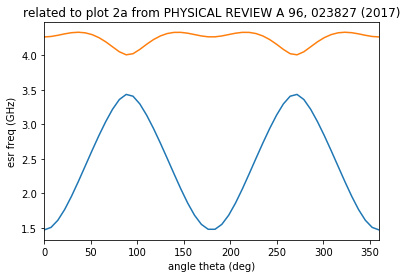

In [42]:
phi = 0
Bo=0.05

thetas = np.linspace(0,2*np.pi,50)

B = np.array([[
    Bo*np.cos(phi)*np.sin(theta),
    Bo*np.sin(phi)*np.sin(theta),
    Bo*np.cos(theta)
    
] for theta in thetas])

for b in nv.esr_frequencies(B).T:
    plt.plot(180/np.pi*thetas, b*1e-9)
    
plt.title('related to plot 2a from PHYSICAL REVIEW A 96, 023827 (2017)')
plt.xlabel('angle theta (deg)')
plt.ylabel('esr freq (GHz)')
plt.xlim([0,360])

### reproduce plot 2b from Tetienne et al.

New Journal of Physics 14 (2012) 103033 (http://www.njp.org/)

Text(0.5,1,'angle to Nv axis 74.0 deg')

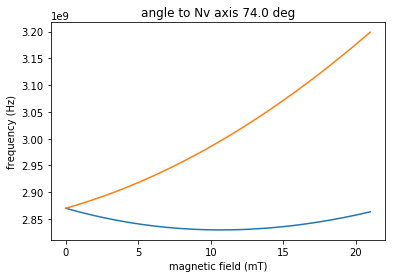

In [38]:
# angle 
# theta = 57*np.pi/180
theta = 74*np.pi/180
# field strength
B_mag = np.linspace(0,0.021,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T
f = nv.esr_frequencies(Bs)

plt.plot(B_mag*1e3, f[:,0])
plt.plot(B_mag*1e3, f[:,1])
plt.xlabel('magnetic field (mT)')
plt.ylabel('frequency (Hz)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

Text(0.5,1,'angle to Nv axis 30.0 deg')

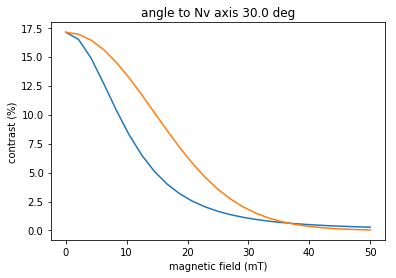

In [3]:
# angle 
# theta = 57*np.pi/180
theta = 74*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))






# angle 
# theta = 57*np.pi/180
theta = 30*np.pi/180
# theta = 30*np.pi/180
# field strength
B_mag = np.linspace(0,0.05,25)


Bs = np.array([B_mag*np.sin(theta), 0.*B_mag*np.sin(theta), B_mag*np.cos(theta)]).T


C = nv.photoluminescence_contrast(Bfield=Bs, k12=10, k13=0, beta=2)
plt.plot(B_mag*1e3,C)

plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))

### show contrast change for all four NV families

In [14]:
theta, phi = nv.nNV_angles[0]
theta, phi


(54.735610317244998, 135.0)

Text(0.5,1,'angle to Nv axis 54.7 deg')

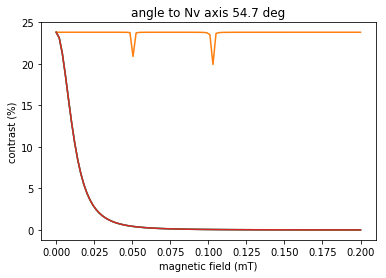

In [31]:
# angle 
# theta = 57*np.pi/180
theta = 54
phi = 0

# check that if the field is aligned with the NV the contrast stays constant
theta, phi = nv.nNV_angles[1]

theta = 54.7 # for small missalignment we get dips at the level crossings
# phi = 0

# convert to radias
theta *= np.pi/180
phi *= np.pi/180
# field strength
B_mag = np.linspace(0,0.20,100)


Bs = np.array([B_mag*np.sin(theta)*np.cos(phi), B_mag*np.sin(theta)*np.sin(phi), B_mag*np.cos(theta)]).T



plt.plot(B_mag, nv.esr_contrast_ensemble(Bs))
plt.xlabel('magnetic field (mT)')
plt.ylabel('contrast (%)')
plt.title('angle to Nv axis {:0.1f} deg'.format(theta*180/np.pi))